# Note:

> # Before runninig this notebook, change the runtime type to **GPU** to make the document to vector embedding faster.




> # Install required Libraries



In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.9 MB/s 
     |████████████████████████████████| 59 kB 5.7 MB/s 
     |████████████████████████████████| 596 kB 38.6 MB/s 
     |████████████████████████████████| 3.3 MB 43.0 MB/s 
     |████████████████████████████████| 895 kB 49.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


> # Import necessary **modules**



In [2]:
from bs4 import BeautifulSoup
import os
from string import punctuation
import re
import numpy as np
import pandas as pd
import torch
import transformers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, balanced_accuracy_score
import nltk
import tensorflow as tf
import math
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import optimizers
from keras.regularizers import l1
from sklearn.decomposition import PCA, KernelPCA
import seaborn as sns

In [3]:
# copy utils function and import
if not os.path.isfile('preprocess_utils.py'):
  !gdown --id 1EsKIkfWO2EyInI1fdMJB-KdrE7DybgIr

Downloading...
From: https://drive.google.com/uc?id=1EsKIkfWO2EyInI1fdMJB-KdrE7DybgIr
To: /content/preprocess_utils.py
100% 6.99k/6.99k [00:00<00:00, 16.8MB/s]


In [4]:
from preprocess_utils import reuters_util

> # Download and extract the dataset 



In [5]:
pathdir = "/content/reuters21578"

In [6]:
def download_dataset():
  if not os.path.isfile('reuters21578-20211110T171613Z-001.zip'):
    !gdown --id 1LEbse_I7hrbPSwgSFGGFDrdlqbG99LUb

  if not os.path.exists(pathdir):
    !unzip reuters21578-20211110T171613Z-001.zip

In [7]:
download_dataset()

Downloading...
From: https://drive.google.com/uc?id=1LEbse_I7hrbPSwgSFGGFDrdlqbG99LUb
To: /content/reuters21578-20211110T171613Z-001.zip
100% 8.02M/8.02M [00:00<00:00, 70.7MB/s]
Archive:  reuters21578-20211110T171613Z-001.zip
  inflating: reuters21578/README.txt  
  inflating: reuters21578/lewis.dtd  
  inflating: reuters21578/cat-descriptions_120396.txt  
  inflating: reuters21578/all-people-strings.lc.txt  
  inflating: reuters21578/all-orgs-strings.lc.txt  
  inflating: reuters21578/all-topics-strings.lc.txt  
  inflating: reuters21578/all-places-strings.lc.txt  
  inflating: reuters21578/all-exchanges-strings.lc.txt  
  inflating: reuters21578/feldman-cia-worldfactbook-data.txt  
  inflating: reuters21578/reut2-020.sgm  
  inflating: reuters21578/reut2-017.sgm  
  inflating: reuters21578/reut2-018.sgm  
  inflating: reuters21578/reut2-016.sgm  
  inflating: reuters21578/reut2-014.sgm  
  inflating: reuters21578/reut2-015.sgm  
  inflating: reuters21578/reut2-013.sgm  
  inflating: 

# Parse the documents and create a pandas dataframe with all features



******** Extract the following features for each document in the reuters data ****:

```
'cgisplit', 'lewissplit', 'newid', 'topics_bool','date','exchanges', 'orgs', 'people', 'places', 'title','text','topics'
```

*   `topic_bool`: tells whether the document has a topic or not
*   `topics`: tells the topic name





In [8]:
# Create object for the reuters_util class
utils_obj = reuters_util()

In [9]:
col_name = ['cgisplit', 'lewissplit', 'newid', 'topics_bool','date','exchanges', 'orgs', 'people', 'places', 'title','text','topics']

reuters_df = pd.DataFrame(columns=col_name)
files = os.listdir(pathdir)
files.sort()
for doc in files:
  if doc.endswith("sgm"):
    print("parsing {}".format(doc))
    doc_path = os.path.join(pathdir, doc)
    reuters_df = utils_obj.parse_doc(doc_path, col_name, reuters_df)

parsing reut2-000.sgm
parsing reut2-001.sgm
parsing reut2-002.sgm
parsing reut2-003.sgm
parsing reut2-004.sgm
parsing reut2-005.sgm
parsing reut2-006.sgm
parsing reut2-007.sgm
parsing reut2-008.sgm
parsing reut2-009.sgm
parsing reut2-010.sgm
parsing reut2-011.sgm
parsing reut2-012.sgm
parsing reut2-013.sgm
parsing reut2-014.sgm
parsing reut2-015.sgm
parsing reut2-016.sgm
parsing reut2-017.sgm
parsing reut2-018.sgm
parsing reut2-019.sgm
parsing reut2-020.sgm


In [10]:
reuters_df.head()

,cgisplit,lewissplit,newid,topics_bool,date,exchanges,orgs,people,places,title,text,topics
0,TRAINING-SET,TRAIN,1,YES,26-FEB-1987 15:01:01.79,None,None,None,"[el-salvador, usa, uruguay]",BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...,[cocoa]
1,TRAINING-SET,TRAIN,2,NO,26-FEB-1987 15:02:20.00,None,None,None,[usa],STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America\nInc said...,None
2,TRAINING-SET,TRAIN,3,NO,26-FEB-1987 15:03:27.51,None,None,None,[usa],TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas\nCommerc...,None
3,TRAINING-SET,TRAIN,4,NO,26-FEB-1987 15:07:13.72,None,None,None,"[usa, brazil]",TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,BankAmerica Corp is not under\npressure to act...,None
4,TRAINING-SET,TRAIN,5,YES,26-FEB-1987 15:10:44.60,None,None,None,[usa],NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...,"[grain, wheat, corn, barley, oat, sorghum]"


In [11]:
reuters_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 20999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cgisplit     21000 non-null  object
 1   lewissplit   21000 non-null  object
 2   newid        21000 non-null  object
 3   topics_bool  21000 non-null  object
 4   date         21000 non-null  object
 5   exchanges    459 non-null    object
 6   orgs         876 non-null    object
 7   people       1129 non-null   object
 8   places       18333 non-null  object
 9   title        20266 non-null  object
 10  text         21000 non-null  object
 11  topics       11038 non-null  object
dtypes: object(12)
memory usage: 2.1+ MB


# Exploratory Data Analysis


In [12]:
reuters_df.head()

,cgisplit,lewissplit,newid,topics_bool,date,exchanges,orgs,people,places,title,text,topics
0,TRAINING-SET,TRAIN,1,YES,26-FEB-1987 15:01:01.79,None,None,None,"[el-salvador, usa, uruguay]",BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...,[cocoa]
1,TRAINING-SET,TRAIN,2,NO,26-FEB-1987 15:02:20.00,None,None,None,[usa],STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America\nInc said...,None
2,TRAINING-SET,TRAIN,3,NO,26-FEB-1987 15:03:27.51,None,None,None,[usa],TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas\nCommerc...,None
3,TRAINING-SET,TRAIN,4,NO,26-FEB-1987 15:07:13.72,None,None,None,"[usa, brazil]",TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,BankAmerica Corp is not under\npressure to act...,None
4,TRAINING-SET,TRAIN,5,YES,26-FEB-1987 15:10:44.60,None,None,None,[usa],NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...,"[grain, wheat, corn, barley, oat, sorghum]"


In [13]:
def frequecy_dist(col_name, df):
  dic = {}
  for val in df[col_name]:
    try:
      for j in val:
        if j in dic.keys():
          dic[j.lower()] += 1
        else:
          dic[j.lower()] = 1
    except TypeError:
      continue
  return pd.Series(dic).sort_values(ascending=False)

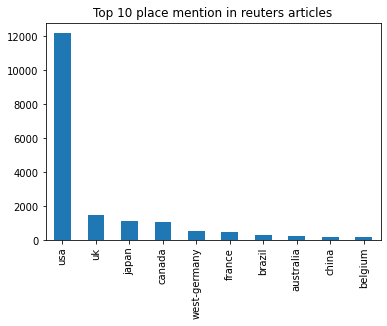

In [14]:
places = frequecy_dist('places', reuters_df)
places[0:10].plot.bar()
plt.title('Top 10 place mention in reuters articles')
plt.show()

- From the above chart, we can see that most 
 articles contain news from the United States, UK, Japan, and Canada. 

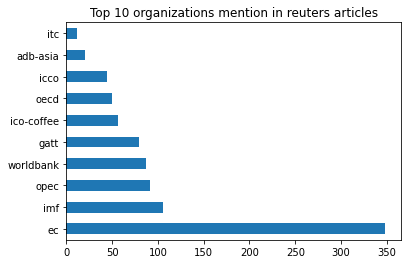

In [15]:
orgs = frequecy_dist('orgs', reuters_df)
orgs[0:10].plot.barh()
plt.title('Top 10 organizations mention in reuters articles')
plt.show()

- From the above graph we can see that Eureopean Commission(ec), IMF, and Opec are the most organizations mentioned in reuters articles.

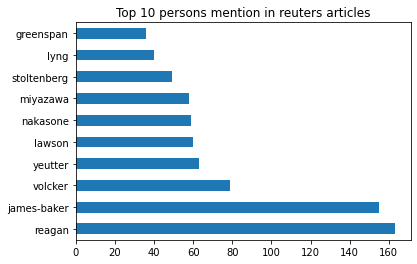

In [16]:
people = frequecy_dist('people', reuters_df)
people[0:10].plot.barh()
plt.title('Top 10 persons mention in reuters articles')
plt.show()

- From the above chart we can see that Reagan and James Baker was the most mentioned persons in the article.

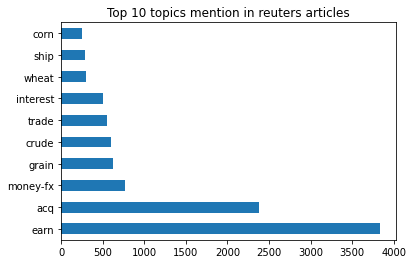

In [17]:
topics = frequecy_dist('topics', reuters_df)
topics[0:10].plot.barh()
plt.title('Top 10 topics mention in reuters articles')
plt.show()

- From the above chart you can see that most of the reuter's articles focus on the topics:
 1. EARN(Earnings and Earnings Forecasts)
 2. ACQ(Mergers/Acquisitions) topics.


In [18]:
# documents which mentioned earn topics
df_earn = reuters_df[reuters_df['topics'].apply(lambda x : True if ('earn' in str(x)) else False)]

In [19]:
df_earn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3836 entries, 8 to 20987
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cgisplit     3836 non-null   object
 1   lewissplit   3836 non-null   object
 2   newid        3836 non-null   object
 3   topics_bool  3836 non-null   object
 4   date         3836 non-null   object
 5   exchanges    3 non-null      object
 6   orgs         0 non-null      object
 7   people       0 non-null      object
 8   places       3663 non-null   object
 9   title        3814 non-null   object
 10  text         3836 non-null   object
 11  topics       3836 non-null   object
dtypes: object(12)
memory usage: 389.6+ KB


- The insight we get from the above table that there is no single organization directly mention in EARN topics.

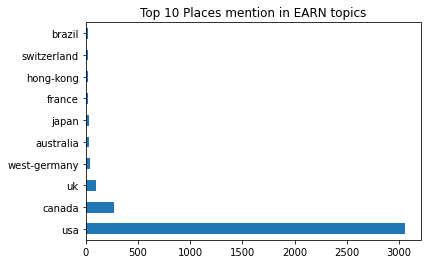

In [20]:
earn_places = frequecy_dist('places', df_earn)
earn_places[0:10].plot.barh()
plt.title('Top 10 Places mention in EARN topics')
plt.show()

- The insight you can get from the above chart that USA, Canada, Uk, and West Germany are top places mention in EARN topics.

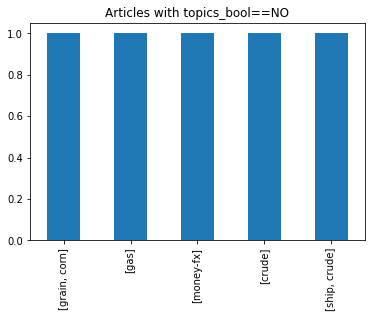

In [21]:
reuters_df[(reuters_df['topics_bool']=='NO') & (reuters_df['topics'].notnull())]['topics'].value_counts().plot.bar()
plt.title('Articles with topics_bool==NO')
plt.show()


- The insight you can get from the above chart that there are 5 documents where topic was not expected to be assigned but they have.

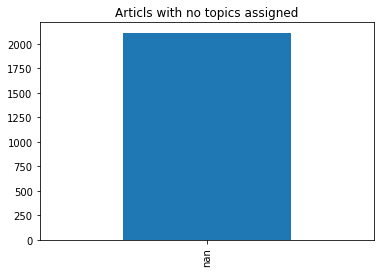

In [22]:
reuters_df[(reuters_df['topics_bool']=='YES') & (reuters_df['topics'].isnull())]['topics'].value_counts(dropna=False).plot.bar()
plt.title('Articls with no topics assigned')
plt.show()


- From the above graph we can see that there are around 2000 documents where it says it has a topic but there is no topic assigned to these documents.




# EDA Summery 
- The above EDA also shows us the majority of the documents are categorized under EARN topics which can tell that it is even possible to have a binary class EARN or Others. The main target here is to correctly classify documents which belong to the earn class.
- There are documents where they are supposed to have a topic but they don't. we need to remove this document from the training data. The reverse also happens but we keep the document because they have a topic.
- All documents which belong to the EARN class don't have a mention of Organization. Hence such attributes aren't useful for our target.



# Clean the dataframe



In [23]:
reuters_df = utils_obj.clean_data(reuters_df.copy())

# Generate text embedding for the documents




In [24]:
# Drop unnecessary columns 
col_drop = ['date', 'exchanges','orgs', 'people', 'places']
reuters_df = reuters_df.drop(columns=col_drop, axis=1)

In [25]:
reuters_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 20999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cgisplit     21000 non-null  object
 1   lewissplit   21000 non-null  object
 2   newid        21000 non-null  object
 3   topics_bool  21000 non-null  object
 4   title        21000 non-null  object
 5   text         21000 non-null  object
 6   topics       11038 non-null  object
dtypes: object(7)
memory usage: 1.3+ MB


- **GPU configuration**

In [26]:
utils_obj.gpu_config()

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80


- **Initialize prebuilt models to do the embeddings**

1.   BERT tokenizer
2.   DistilBERT
3.   NLTK

In [27]:
utils_obj.initialize_prebuilt_models()

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [28]:
reuters_df['text_embedding'] = reuters_df['text'].apply(utils_obj.doc_to_vectors)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [29]:
reuters_df['title_embedding'] = reuters_df['title'].apply(utils_obj.doc_to_vectors)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [30]:
reuters_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 20999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cgisplit         21000 non-null  object
 1   lewissplit       21000 non-null  object
 2   newid            21000 non-null  object
 3   topics_bool      21000 non-null  object
 4   title            21000 non-null  object
 5   text             21000 non-null  object
 6   topics           11038 non-null  object
 7   text_embedding   21000 non-null  object
 8   title_embedding  21000 non-null  object
dtypes: object(9)
memory usage: 1.6+ MB


> # Prepare train and Test datasets


In [32]:
def train_test_data_split(data):
  pd.options.mode.chained_assignment = None  # default='warn'

  # use ModApte train and test split technique
  train_data = data[(data['lewissplit']=='TRAIN') & (data['topics_bool']=='YES')]

  # screen out the training data with no TOPICS categories.
  train_data = train_data.dropna(subset=['topics'])
  train_data.reset_index(drop=True, inplace=True)

  test_data = data[(data['lewissplit']=='TEST') & (data['topics_bool']=='YES')]
  test_data.reset_index(drop=True, inplace=True)

  # replace test data null value by zero list.
  test_data['topics'] = test_data['topics'].fillna(0)

  # divide the topics into a binary class earn or not earn. i.e earn=1, not_earn=0
  train_data['topics'] = [1 if 'earn' in str(topic) else 0 for topic in train_data['topics']]
  test_data['topics'] = [1 if 'earn' in str(topic) else 0 for topic in test_data['topics']]

  train = utils_obj.generate_final_embedding(train_data)
  test = utils_obj.generate_final_embedding(test_data)

  return train, test

In [33]:
train_data, test_data = train_test_data_split(reuters_df)

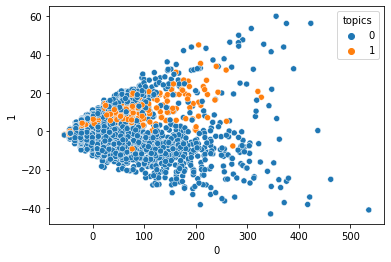

In [34]:
def do_pca_plot(df):
  pca = PCA(n_components = 2) 
  X_pca = pd.DataFrame(pca.fit_transform(df.drop("topics", axis=1)))
  X_pca['topics'] = df['topics']
  sns.scatterplot(data=X_pca, x=0, y=1, hue='topics')

do_pca_plot(train_data)

In [ ]:
# 1 class represents EARN topics and 0 class represents OTHERS.

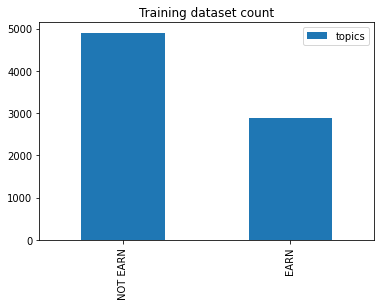

In [35]:
train_data['topics'].value_counts().set_axis(['NOT EARN','EARN']).plot.bar()
plt.title("Training dataset count")
plt.legend()
plt.show()

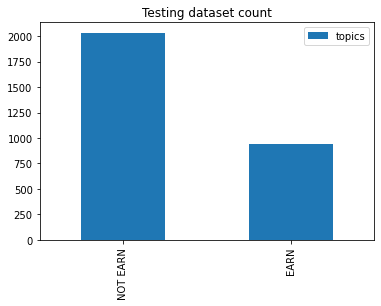

In [36]:
test_data['topics'].value_counts().set_axis(['NOT EARN','EARN']).plot.bar()
plt.title("Testing dataset count")
plt.legend()
plt.show()

In [ ]:
# Save preprocessed dataset for later use
# train.to_csv("train_reuters_data.csv", index=False)
# test.to_csv("test_reuters_data.csv", index=False)

# Statical Modeling

The problem has become a classification problem with a binary classes **earn** or 1 and **not-earn** or 0 class. The classifier proposed is to use a ANN model with a Single hidden layer feed-forward Neural Network.

In [37]:
def train_model(train_data, batch_size=16, epochs=100, random_state=42):
  # Prepare the dataset for the model
  y_train, x_train = train_data['topics'], train_data.iloc[:, 0:-1]

  # Further devide the training data into train and validation set
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3, random_state = random_state)

  # Initialising the ANN
  classifier = Sequential()

  # Adding the input layer and hidden layer
  classifier.add(Dense(units = 512, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train.shape[1]))

  # Adding the output layer
  classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  classifier.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data=(x_val, y_val))

  return classifier

In [38]:
def do_prediction(test_data, classifier, treshold_val=0.5):
  y_test, x_test = test_data['topics'], test_data.iloc[:, 0:-1]
  # Prediction results
  y_pred = classifier.predict(x_test)
  y_pred = (y_pred > treshold_val)
  y_pred = y_pred * 1
  # Create a dataframe for actual vs predicted class
  result_df = pd.DataFrame()
  result_df["actual_class"], result_df["pred_class"] = y_test, y_pred
  return result_df

In [39]:
def model_scoring(actual_vs_pred_result):
  # calculate precision, recall, auc and balanced_accuracy
  y_true = actual_vs_pred_result["actual_class"]
  y_pred = actual_vs_pred_result["pred_class"]
  recall_0, recall_1 = recall_score(y_true, y_pred, average=None)
  precision_0, precision_1  = precision_score(y_true, y_pred, average=None)
  balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
  auc = roc_auc_score(y_true, y_pred, average=None)
  metrics_df = pd.DataFrame([[precision_0, precision_1, recall_0, recall_1, auc, balanced_accuracy]], columns=["precision_0_class", "precision_1_class", "recall_0_class", "recall_1_class", "auc", "balanced_accuracy"])
  return metrics_df

In [40]:
# Train model
classifier_model = train_model(train_data)

Epoch 1/100
341/341 [==============================] - 5s 7ms/step - loss: 0.2615 - accuracy: 0.9118 - val_loss: 0.1155 - val_accuracy: 0.9571
Epoch 2/100
341/341 [==============================] - 2s 6ms/step - loss: 0.1224 - accuracy: 0.9570 - val_loss: 0.1078 - val_accuracy: 0.9657
Epoch 3/100
341/341 [==============================] - 2s 6ms/step - loss: 0.1091 - accuracy: 0.9625 - val_loss: 0.0935 - val_accuracy: 0.9721
Epoch 4/100
341/341 [==============================] - 2s 5ms/step - loss: 0.0776 - accuracy: 0.9717 - val_loss: 0.0777 - val_accuracy: 0.9764
Epoch 5/100
341/341 [==============================] - 2s 6ms/step - loss: 0.0710 - accuracy: 0.9756 - val_loss: 0.1213 - val_accuracy: 0.9593
Epoch 6/100
341/341 [==============================] - 2s 6ms/step - loss: 0.0650 - accuracy: 0.9778 - val_loss: 0.1290 - val_accuracy: 0.9597
Epoch 7/100
341/341 [==============================] - 2s 5ms/step - loss: 0.0550 - accuracy: 0.9800 - val_loss: 0.1318 - val_accuracy: 0.9614

In [41]:
# Test model
prediction_result = do_prediction(test_data, classifier_model)

In [42]:
prediction_result.head()

,actual_class,pred_class
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [43]:
# Scoring 
model_score = model_scoring(prediction_result)
model_score

,precision_0_class,precision_1_class,recall_0_class,recall_1_class,auc,balanced_accuracy
0,0.992926,0.932323,0.967028,0.985059,0.976043,0.976043


# Save Model

In [44]:
os.makedirs('/content/model', exist_ok=True)
classifier_model.save('/content/model/keras_model.h5')